# Integrating single-cell transcriptomes from multiple samples

## Install the required libraries

In [ ]:
download.file("https://github.com/eddelbuettel/r2u/raw/master/inst/scripts/add_cranapt_jammy.sh",
              "add_cranapt_jammy.sh")
Sys.chmod("add_cranapt_jammy.sh", "0755")
system("./add_cranapt_jammy.sh")
bspm::enable()
options(bspm.version.check=FALSE)

Tracing function "install.packages" in package "utils"



We will create an R function to performs system calls

In [ ]:
shell_call <- function(command, ...) {
  result <- system(command, intern = TRUE, ...)
  cat(paste0(result, collapse = "\n"))
}

Install required libraries

In [ ]:
install.packages("R.utils")

remotes::install_github('satijalab/seurat-wrappers@d28512f804d5fe05e6d68900ca9221020d52cf1d', upgrade=F)
remotes::install_github('satijalab/seurat-data')
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager", quiet = T)
install.packages("harmony")


Installing 72 packages: Rcpp, sitmo, BH, dqrng, RcppProgress, irlba, RcppAnnoy, FNN, polyclip, deldir, spatstat.utils, spatstat.data, tensor, abind, goftest, spatstat.sparse, spatstat.random, spatstat.geom, promises, later, sourcetools, xtable, httpuv, parallelly, listenv, globals, RcppEigen, progressr, future.apply, future, sp, plyr, RcppArmadillo, matrixStats, gridExtra, reshape2, bitops, caTools, gtools, gplots, png, here, RcppTOML, crosstalk, lazyeval, htmlwidgets, shiny, zoo, igraph, reticulate, uwot, spatstat.explore, SeuratObject, sctransform, scattermore, Rtsne, ROCR, RANN, plotly, pbapply, patchwork, miniUI, lmtest, leiden, ica, ggridges, ggrepel, fitdistrplus, cowplot, Seurat, rsvd, BiocManager



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpngHZzd/remotes3ca76207eab/satijalab-seurat-wrappers-d28512f/DESCRIPTION’ ... OK
* preparing ‘SeuratWrappers’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘SeuratWrappers_0.3.1.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)





── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpngHZzd/remotes3ca6f36acb7/satijalab-seurat-data-d6a8ce6/DESCRIPTION’ ... OK
* preparing ‘SeuratData’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘SeuratData_0.2.2.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Introduction

In this example of integrating multiple datasets representing, for example, different biological conditions, sample handling, or experimental protocols, we will explore the integration performed by [Seurat](https://www.cell.com/cell/fulltext/S0092-8674(19)30559-8) and [Harmony](https://www.nature.com/articles/s41592-019-0619-0) separately.

In [ ]:
library(Seurat)
library(SeuratData)
library(SeuratWrappers)
library(cowplot)
library(harmony)
options(timeout=2000)

Attaching SeuratObject

‘SeuratObject’ was built under R 4.3.0 but the current version is
4.3.1; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

Loading required package: Rcpp



## Loading Data

Here we load our datasets of interest to perform the integration.

This tutorial walks through an alignment of two groups of PBMCs from [Kang et al, 2017](https://www.nature.com/articles/nbt.4042). In this experiment, PBMCs were split into a stimulated and control group and the stimulated group was treated with interferon beta. The response to interferon caused cell type specific gene expression changes that makes a joint analysis of all the data difficult, with cells clustering both by stimulation condition and by cell type.

In [ ]:
# install dataset
InstallData("ifnb")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# load dataset
LoadData("ifnb")

An object of class Seurat 
14053 features across 13999 samples within 1 assay 
Active assay: RNA (14053 features, 0 variable features)

In [ ]:
sc_datasets <- ifnb

In [ ]:
sc_datasets %>% dplyr::glimpse()

Formal class 'Seurat' [package "Seurat"] with 13 slots


Warning message:
“Not a validObject(): no slot of name "images" for this object of class "Seurat"”


  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay' [package "Seurat"] with 8 slots


Warning message:
“Not a validObject(): no slot of name "assay.orig" for this object of class "Assay"”


  ..@ meta.data   :'data.frame':	13999 obs. of  5 variables:
  .. ..$ orig.ident        : chr [1:13999] "IMMUNE_CTRL" "IMMUNE_CTRL" "IMMUNE_CTRL" "IMMUNE_CTRL" ...
  .. ..$ nCount_RNA        : num [1:13999] 3017 2481 3420 3156 1868 ...
  .. ..$ nFeature_RNA      : int [1:13999] 877 713 850 1109 634 557 980 581 880 669 ...
  .. ..$ stim              : chr [1:13999] "CTRL" "CTRL" "CTRL" "CTRL" ...
  .. ..$ seurat_annotations: Factor w/ 13 levels "CD14 Mono","CD4 Naive T",..: 1 1 1 12 3 1 7 2 6 1 ...
  ..@ active.assay: chr "RNA"
  ..@ active.ident: Factor w/ 2 levels "IMMUNE_CTRL",..: 1 1 1 1 1 1 1 1 1 1 ...
  .. ..- attr(*, "names")= chr [1:13999] "AAACATACATTTCC.1" "AAACATACCAGAAA.1" "AAACATACCTCGCT.1" "AAACATACCTGGTA.1" ...
  ..@ graphs      : list()
  ..@ neighbors   : list()
  ..@ reductions  : list()
  ..@ project.name: chr "ifnb"
  ..@ misc        : list()
  ..@ version     :Classes 'package_version', 'numeric_version'  hidden list of 1
  .. ..$ : int [1:3] 3 0 0
  ..@ commands   

## Data Preprocessing

We preprocess the data to a point that is in common for both Seurat and Harmony data integration,

In [ ]:
sc_datasets <- Seurat::NormalizeData(sc_datasets, verbose = FALSE)

Here, NormalizeData performs a normalization wherein feature counts for each cell are divided by the total counts for that cell and multiplied by the scale.factor. This is then natural-log transformed using log1p.

In [ ]:
dplyr::glimpse(sc_datasets)

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay' [package "Seurat"] with 8 slots


Warning message:
“Not a validObject(): no slot of name "assay.orig" for this object of class "Assay"”


  ..@ meta.data   :'data.frame':	13999 obs. of  5 variables:
  .. ..$ orig.ident        : chr [1:13999] "IMMUNE_CTRL" "IMMUNE_CTRL" "IMMUNE_CTRL" "IMMUNE_CTRL" ...
  .. ..$ nCount_RNA        : num [1:13999] 3017 2481 3420 3156 1868 ...
  .. ..$ nFeature_RNA      : int [1:13999] 877 713 850 1109 634 557 980 581 880 669 ...
  .. ..$ stim              : chr [1:13999] "CTRL" "CTRL" "CTRL" "CTRL" ...
  .. ..$ seurat_annotations: Factor w/ 13 levels "CD14 Mono","CD4 Naive T",..: 1 1 1 12 3 1 7 2 6 1 ...
  ..@ active.assay: chr "RNA"
  ..@ active.ident: Factor w/ 2 levels "IMMUNE_CTRL",..: 1 1 1 1 1 1 1 1 1 1 ...
  .. ..- attr(*, "names")= chr [1:13999] "AAACATACATTTCC.1" "AAACATACCAGAAA.1" "AAACATACCTCGCT.1" "AAACATACCTGGTA.1" ...
  ..@ graphs      : list()
  ..@ neighbors   : list()
  ..@ reductions  : list()
  ..@ images      : list()
  ..@ project.name: chr "ifnb"
  ..@ misc        : list()
  ..@ version     :Classes 'package_version', 'numeric_version'  hidden list of 1
  .. ..$ : int [1

## Run Seurat data integration

The integration performed here with Seurat consists of using a Canonical Correlation Analysis to identify anchors between datasets, as indicated in the [original paper](https://www.cell.com/cell/fulltext/S0092-8674(19)30559-8):

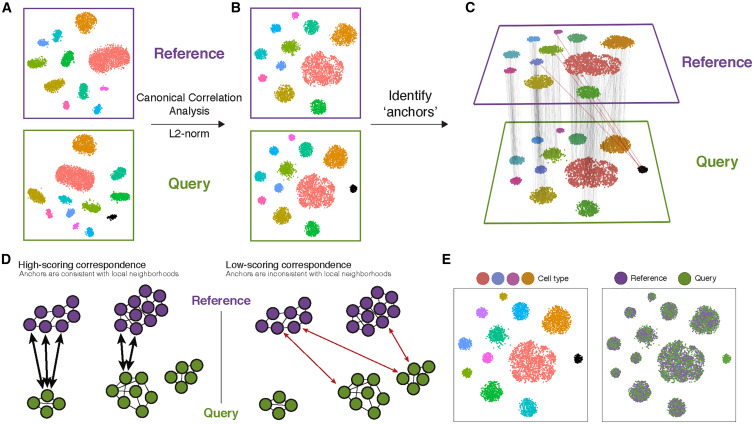

Split dataset into a list of datasets

In [ ]:
sc_datasets.list <- SplitObject(sc_datasets,split.by = "stim")

Find highly variable features for each condition separately

In [ ]:
sc_datasets.list <- lapply(X = sc_datasets.list, FUN = function(x) {
                    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
                    })

Find the features that are repeatedly variable across datasets for integration (anchor features).

In [ ]:
features <- SelectIntegrationFeatures(object.list = sc_datasets.list)

Find the integration anchors or final set of highly variable genes most frequently selected across the batches

In [ ]:
sc_datasets.anchors <- FindIntegrationAnchors(object.list = sc_datasets.list, anchor.features = features)

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 16393 anchors

Filtering anchors

	Retained 6756 anchors



Integrate datasets - Creates an integrated data assay

In [ ]:
sc_datasets.combined <- IntegrateData(anchorset = sc_datasets.anchors)

Merging dataset 1 into 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data



In [ ]:
dplyr::glimpse(sc_datasets.combined)

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 2
  .. ..$ RNA       :Formal class 'Assay' [package "SeuratObject"] with 8 slots
  .. ..$ integrated:Formal class 'Assay' [package "SeuratObject"] with 8 slots
  ..@ meta.data   :'data.frame':	13999 obs. of  5 variables:
  .. ..$ orig.ident        : chr [1:13999] "IMMUNE_CTRL" "IMMUNE_CTRL" "IMMUNE_CTRL" "IMMUNE_CTRL" ...
  .. ..$ nCount_RNA        : num [1:13999] 3017 2481 3420 3156 1868 ...
  .. ..$ nFeature_RNA      : int [1:13999] 877 713 850 1109 634 557 980 581 880 669 ...
  .. ..$ stim              : chr [1:13999] "CTRL" "CTRL" "CTRL" "CTRL" ...
  .. ..$ seurat_annotations: chr [1:13999] "CD14 Mono" "CD14 Mono" "CD14 Mono" "pDC" ...
  ..@ active.assay: chr "integrated"
  ..@ active.ident: Factor w/ 2 levels "IMMUNE_CTRL",..: 1 1 1 1 1 1 1 1 1 1 ...
  .. ..- attr(*, "names")= chr [1:13999] "AAACATACATTTCC.1" "AAACATACCAGAAA.1" "AAACATACCTCGCT.1" "AAACATACCTGGTA.1" ...
  ..@ graphs      : list(

Run the standard workflow for visualization and clustering.

In [ ]:
sc_datasets.combined <- ScaleData(sc_datasets.combined, verbose = FALSE) %>%
                        RunPCA(npcs = 30, verbose = FALSE) %>%
                        RunUMAP(reduction = "pca", dims = 1:30) %>%
                        FindNeighbors(reduction = "pca", dims = 1:30) %>%
                        FindClusters(resolution = 0.5)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
18:59:58 UMAP embedding parameters a = 0.9922 b = 1.112

18:59:58 Read 13999 rows and found 30 numeric columns

18:59:58 Using Annoy for neighbor search, n_neighbors = 30

18:59:58 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:00:01 Writing NN index file to temp file /tmp/RtmpngHZzd/file3ca364ca465

19:00:01 Searching Annoy index using 1 thread, search_k = 3000

19:00:08 Annoy recall = 100%

19:00:09 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors =

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 13999
Number of edges: 568996

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9056
Number of communities: 15
Elapsed time: 3 seconds


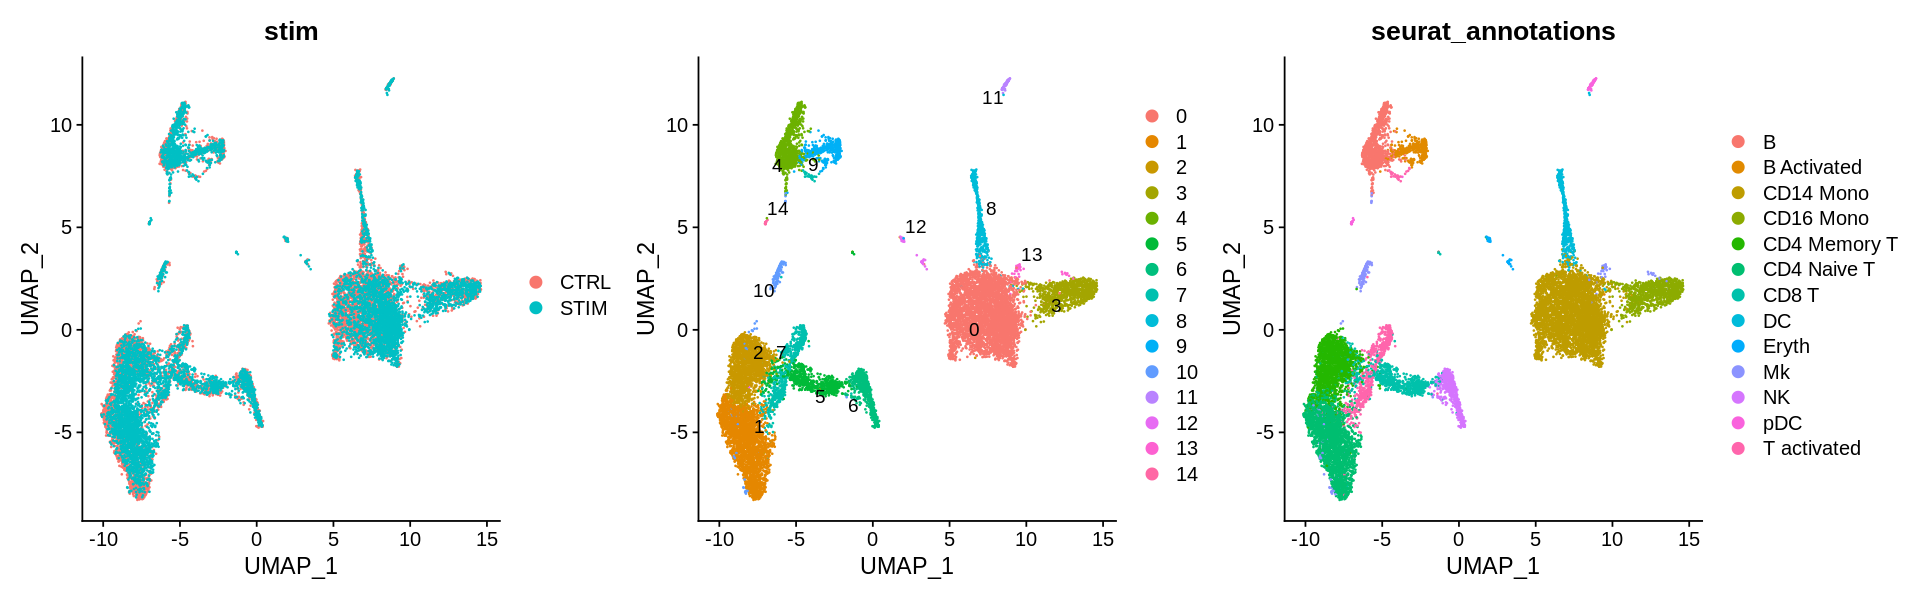

In [ ]:
options(repr.plot.height = 5, repr.plot.width = 16)
# Visualization
p1 <- DimPlot(sc_datasets.combined, reduction = "umap", group.by = "stim")
p2 <- DimPlot(sc_datasets.combined, reduction = "umap", label = TRUE, repel = TRUE)
p3 <- DimPlot(sc_datasets.combined, reduction = "umap", group.by = "seurat_annotations")
p1 + p2 + p3

## Run Harmony

From the [original paper](https://www.nature.com/articles/s41592-019-0619-0) of harmony: "PCA embeds cells into a space with reduced dimensionality. Harmony accepts the cell coordinates in this reduced space and runs an iterative algorithm to adjust for dataset specific effects. **a**, Harmony uses fuzzy clustering to assign each cell to multiple clusters, while a penalty term ensures that the diversity of datasets within each cluster is maximized. **b**, Harmony calculates a global centroid for each cluster, as well as dataset-specific centroids for each cluster. **c**, Within each cluster, Harmony calculates a correction factor for each dataset based on the centroids. **d**, Finally, Harmony corrects each cell with a cell-specific factor: a linear combination of dataset correction factors weighted by the cell’s soft cluster assignments made in step a. Harmony repeats steps a to d until convergence. The dependence between cluster assignment and dataset diminishes with each round. Datasets are represented with colors, cell types with different shapes."

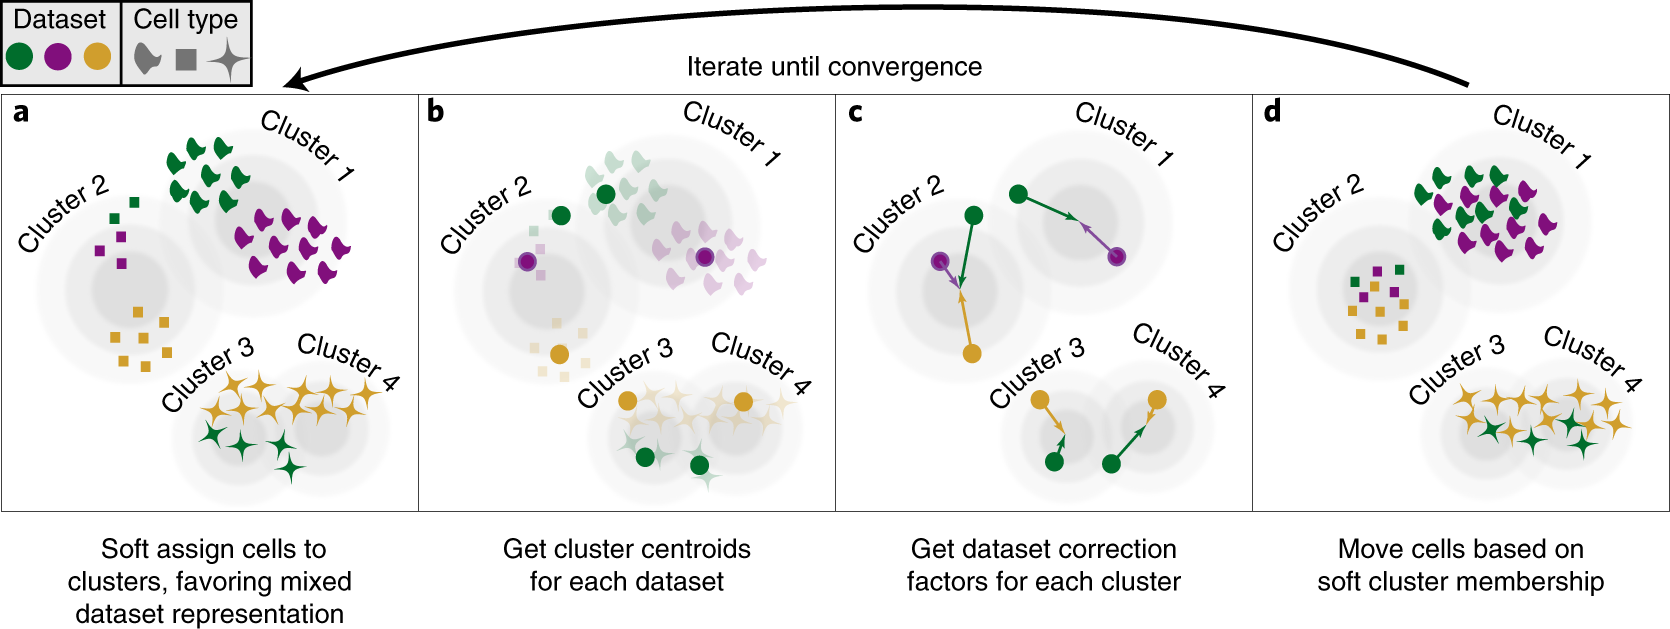



Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony converged after 8 iterations

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


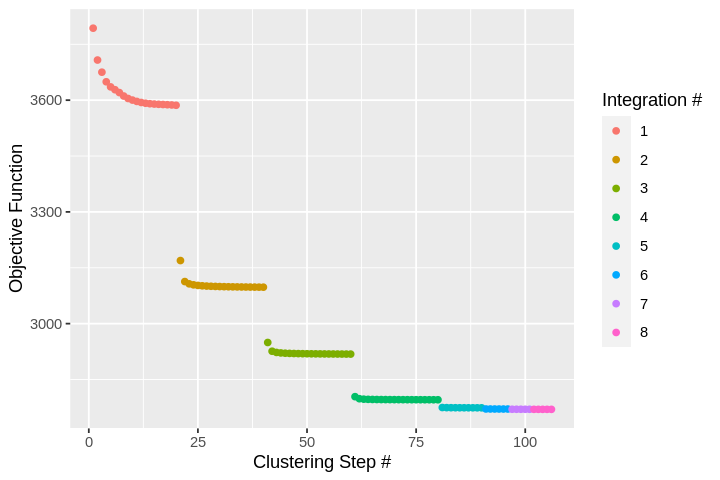

In [ ]:
options(repr.plot.height = 4, repr.plot.width = 6)
sc_datasets.harmony <- FindVariableFeatures(sc_datasets, selection.method = "vst", nfeatures = 2000) %>%
                       ScaleData(verbose = FALSE) %>%
                       RunPCA(npcs = 30, verbose = FALSE) %>%
                       RunHarmony("stim", plot_convergence = TRUE)

To directly access the harmonized embeddings:


In [ ]:
harmony_embeddings <- Embeddings(sc_datasets.harmony, 'harmony')
harmony_embeddings[1:5, 1:5]

,harmony_1,harmony_2,harmony_3,harmony_4,harmony_5
AAACATACATTTCC.1,-11.5210321,0.9726455,1.8217702,-0.04962695,0.3159641
AAACATACCAGAAA.1,-12.0659869,2.5494058,-2.7551658,-0.41883772,-1.6073458
AAACATACCTCGCT.1,-9.6663795,2.5999355,-0.3287142,-0.85152700,0.4931973
AAACATACCTGGTA.1,0.8998847,-1.9753277,13.4134572,5.97503886,-1.2688922
AAACATACGATGAA.1,7.1213880,0.1089806,-1.4102439,-2.58494298,-0.1798715


Complete the standard workflow for visualization and clustering

In [ ]:
sc_datasets.harmony <- RunUMAP(sc_datasets.harmony, reduction = "harmony", dims = 1:30) %>%
                       FindNeighbors(reduction = "harmony", dims = 1:30) %>%
                       FindClusters(resolution = 0.5)

19:01:04 UMAP embedding parameters a = 0.9922 b = 1.112

19:01:04 Read 13999 rows and found 30 numeric columns

19:01:04 Using Annoy for neighbor search, n_neighbors = 30

19:01:04 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:01:06 Writing NN index file to temp file /tmp/RtmpngHZzd/file3ca72595444

19:01:07 Searching Annoy index using 1 thread, search_k = 3000

19:01:14 Annoy recall = 100%

19:01:15 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

19:01:17 Initializing from normalized Laplacian + noise (using irlba)

19:01:17 Commencing optimization for 200 epochs, with 618918 positive edges

19:01:26 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 13999
Number of edges: 519906

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8983
Number of communities: 14
Elapsed time: 3 seconds


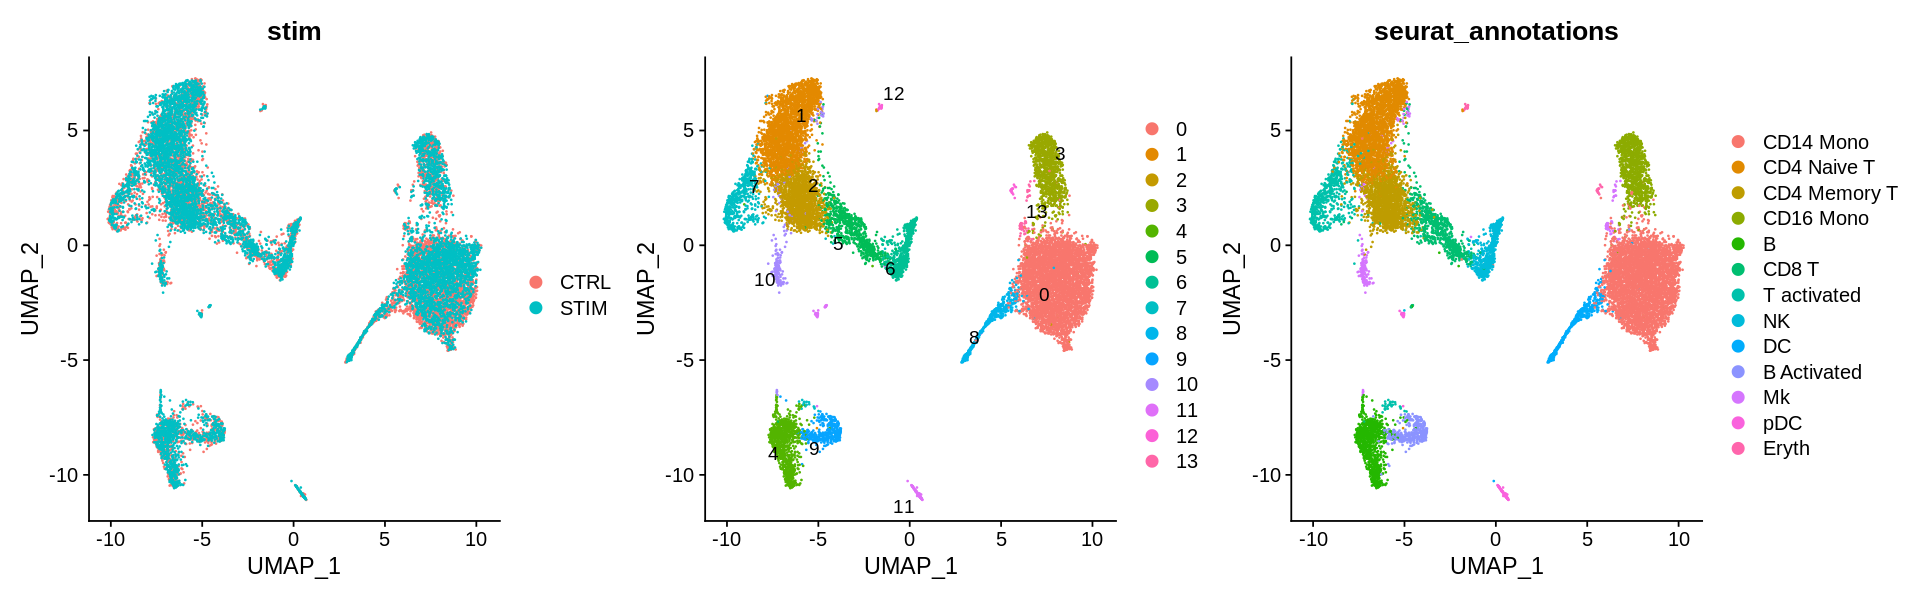

In [ ]:
options(repr.plot.height = 5, repr.plot.width = 16)
# Visualization
p1 <- DimPlot(sc_datasets.harmony, reduction = "umap", group.by = "stim")
p2 <- DimPlot(sc_datasets.harmony, reduction = "umap", label = TRUE, repel = TRUE)
p3 <- DimPlot(sc_datasets.harmony, reduction = "umap", group.by = "seurat_annotations")
p1 + p2 + p3

## Integration Metrics

Inspect mixing within cluster

We will use a function to plot the batch composition of each cluster.

This function was borrowed from: https://github.com/cellgeni/scRNA.seq.course/blob/master/course_files/utils/custom_seurat_functions.R

In [ ]:
plot_integrated_clusters = function (srat, batchcolumn) {
  ## take an integrated Seurat object, plot distributions over orig.ident
  library(Seurat)
  library(patchwork)
  library(ggplot2)
  library(reshape2)
  library(RColorBrewer)


  count_table <- table(srat@meta.data$seurat_clusters, srat@meta.data[[batchcolumn]])
  count_mtx   <- as.data.frame.matrix(count_table)
  count_mtx$cluster <- rownames(count_mtx)
  melt_mtx    <- melt(count_mtx)
  melt_mtx$cluster <- as.factor(melt_mtx$cluster)

  cluster_size   <- aggregate(value ~ cluster, data = melt_mtx, FUN = sum)

  sorted_labels <- paste(sort(as.integer(levels(cluster_size$cluster)),decreasing = T))
  cluster_size$cluster <- factor(cluster_size$cluster,levels = sorted_labels)
  melt_mtx$cluster <- factor(melt_mtx$cluster,levels = sorted_labels)

  colnames(melt_mtx)[2] <- "dataset"


  p1 <- ggplot(cluster_size, aes(y= cluster,x = value)) + geom_bar(position="dodge", stat="identity",fill = "grey60") +
    theme_bw() + scale_x_log10() + xlab("Cells per cluster, log10 scale") + ylab("")
  p2 <- ggplot(melt_mtx,aes(x=cluster,y=value,fill=dataset)) +
    geom_bar(position="fill", stat="identity") + theme_bw() + coord_flip() +
    scale_fill_brewer(palette = "Set2") +
    ylab("Fraction of cells in each dataset") + xlab("Cluster number") + theme(legend.position="top")

  p2 + p1 + plot_layout(widths = c(3,1))
  }


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots


Using cluster as id variables



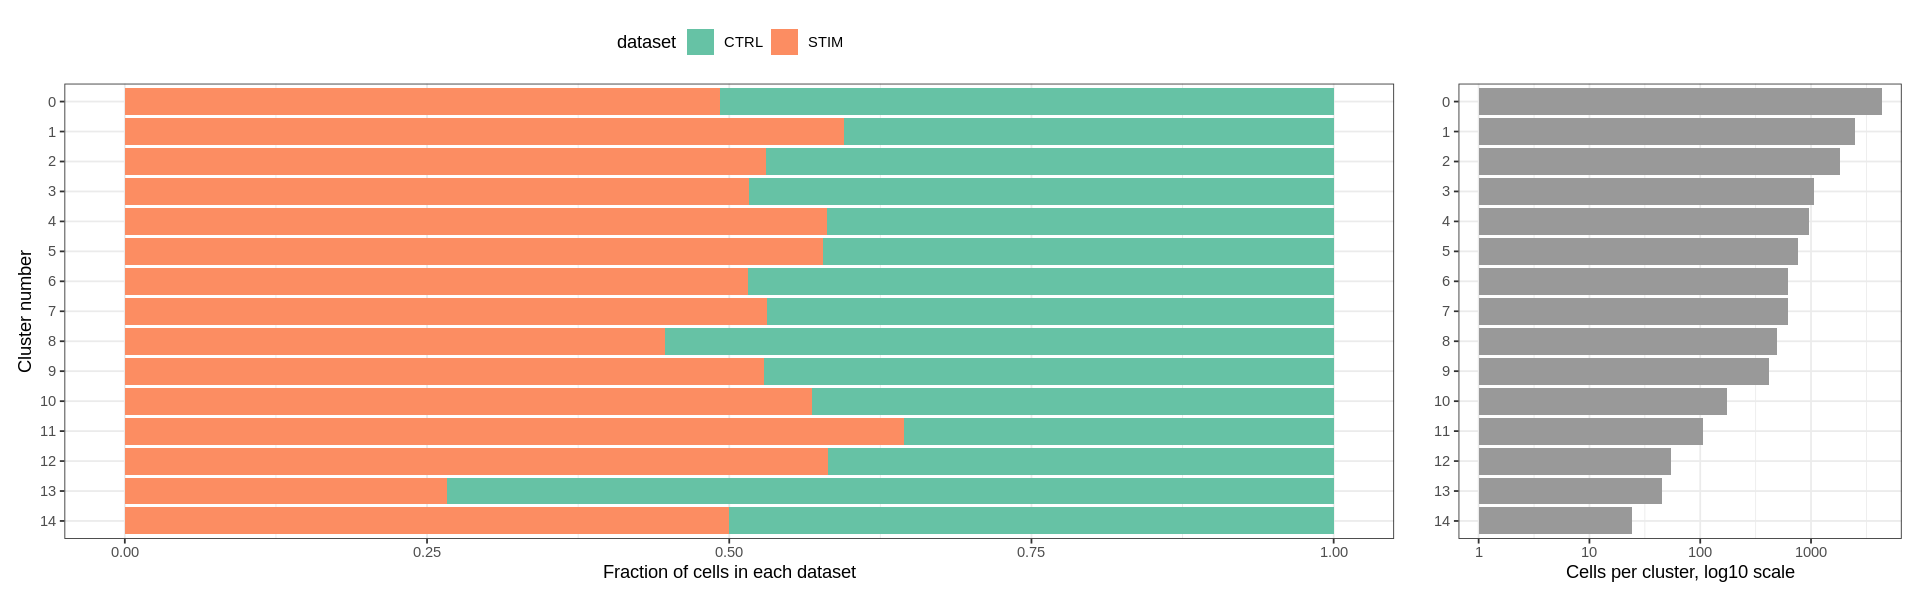

In [ ]:
plot_integrated_clusters(sc_datasets.combined, 'stim')

Using cluster as id variables



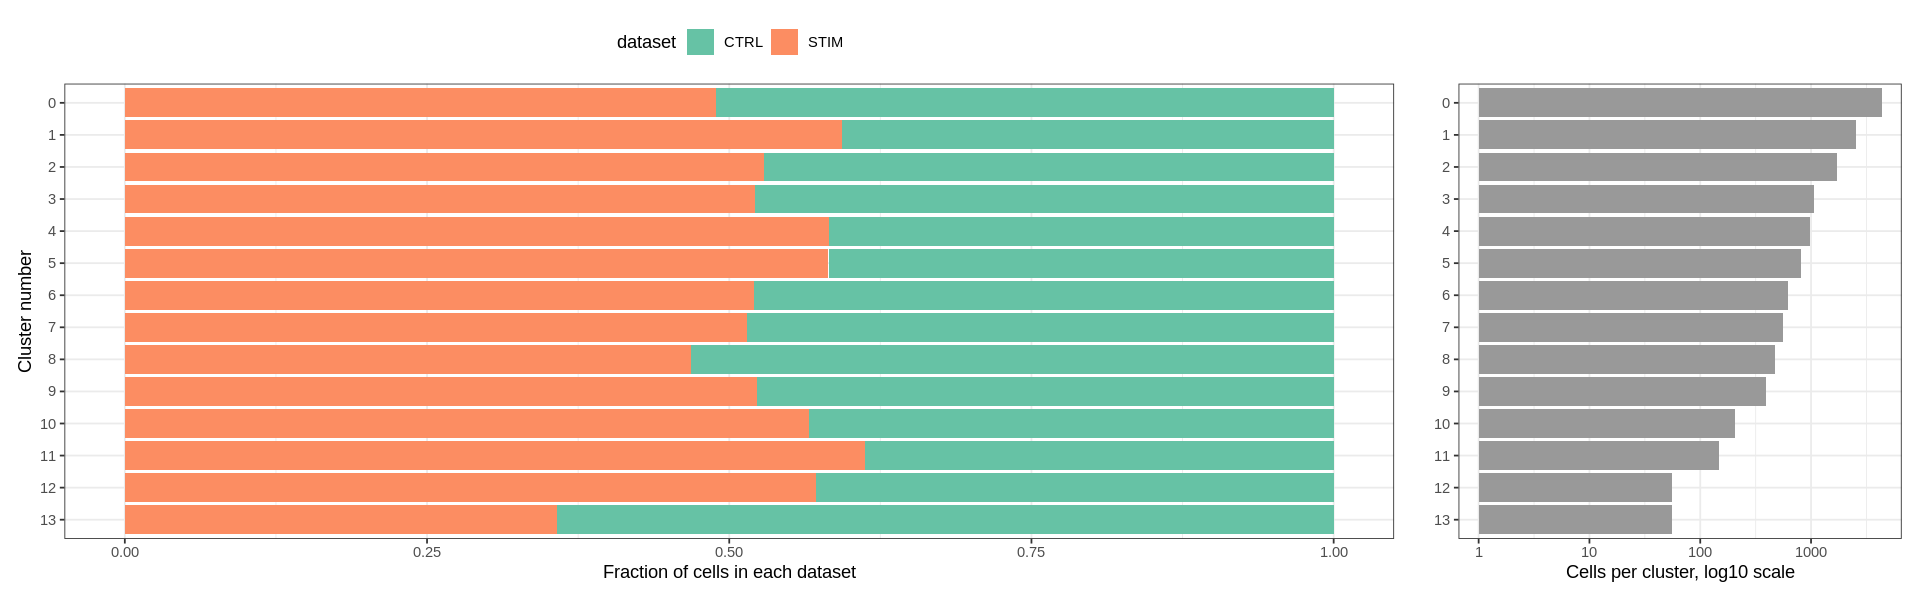

In [ ]:
plot_integrated_clusters(sc_datasets.harmony, 'stim')

This measures how well mixed a composite dataset is. According to [this link](https://github.com/satijalab/Integration2019/issues/1#issuecomment-573757488), lower scores represent better mixing. See also [this code](https://github.com/satijalab/Integration2019/blob/e5821bd242fa0a46eb6fd37764275737512032a4/analysis_code/integration/integration_metrics.R#L43C1-L45C124)

This metric evaluates whether the neighborhood of a cell is well mixed. In other words, whether it contains a small number of cells from each dataset (e.g., k=5).

In [ ]:
seurat_mixing <- MixingMetric(sc_datasets.combined,
                              'seurat_clusters', # 'cca.aligned'
                              reduction = "pca",
                              dims = 1:2,
                              k = 5,
                              max.k = 300,
                              eps = 0,
                              verbose = TRUE
                             )

In [ ]:
mean(seurat_mixing)

[1] 299.7066

In [ ]:
sd(seurat_mixing)

[1] 5.752467

In [ ]:
harmony_mixing <- MixingMetric(sc_datasets.harmony,
                               'seurat_clusters',
                               reduction = "harmony",
                               dims = 1:2,
                               k = 5,
                               max.k = 300,
                               eps = 0,
                               verbose = TRUE
                             )

In [ ]:
mean(harmony_mixing)

[1] 281.8364

In [ ]:
sd(harmony_mixing)

[1] 40.28123

# Let's compare when using no integration, Seurat, and Harmony:

In [ ]:
sc_datasets <-  FindVariableFeatures(sc_datasets, selection.method = "vst", nfeatures = 2000) %>%
                ScaleData(verbose = FALSE) %>%
                RunPCA(npcs = 30, verbose = FALSE) %>%
                RunUMAP(reduction = "pca", dims = 1:30) %>%
                FindNeighbors(reduction = "pca", dims = 1:30) %>%
                FindClusters(resolution = 0.5)

19:02:55 UMAP embedding parameters a = 0.9922 b = 1.112

19:02:55 Read 13999 rows and found 30 numeric columns

19:02:55 Using Annoy for neighbor search, n_neighbors = 30

19:02:55 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:02:59 Writing NN index file to temp file /tmp/RtmpngHZzd/file3ca44c1ecac

19:02:59 Searching Annoy index using 1 thread, search_k = 3000

19:03:05 Annoy recall = 100%

19:03:06 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

19:03:07 Initializing from normalized Laplacian + noise (using irlba)

19:03:08 Commencing optimization for 200 epochs, with 614362 positive edges

19:03:16 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 13999
Number of edges: 557766

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9256
Number of communities: 16
Elapsed time: 3 seconds


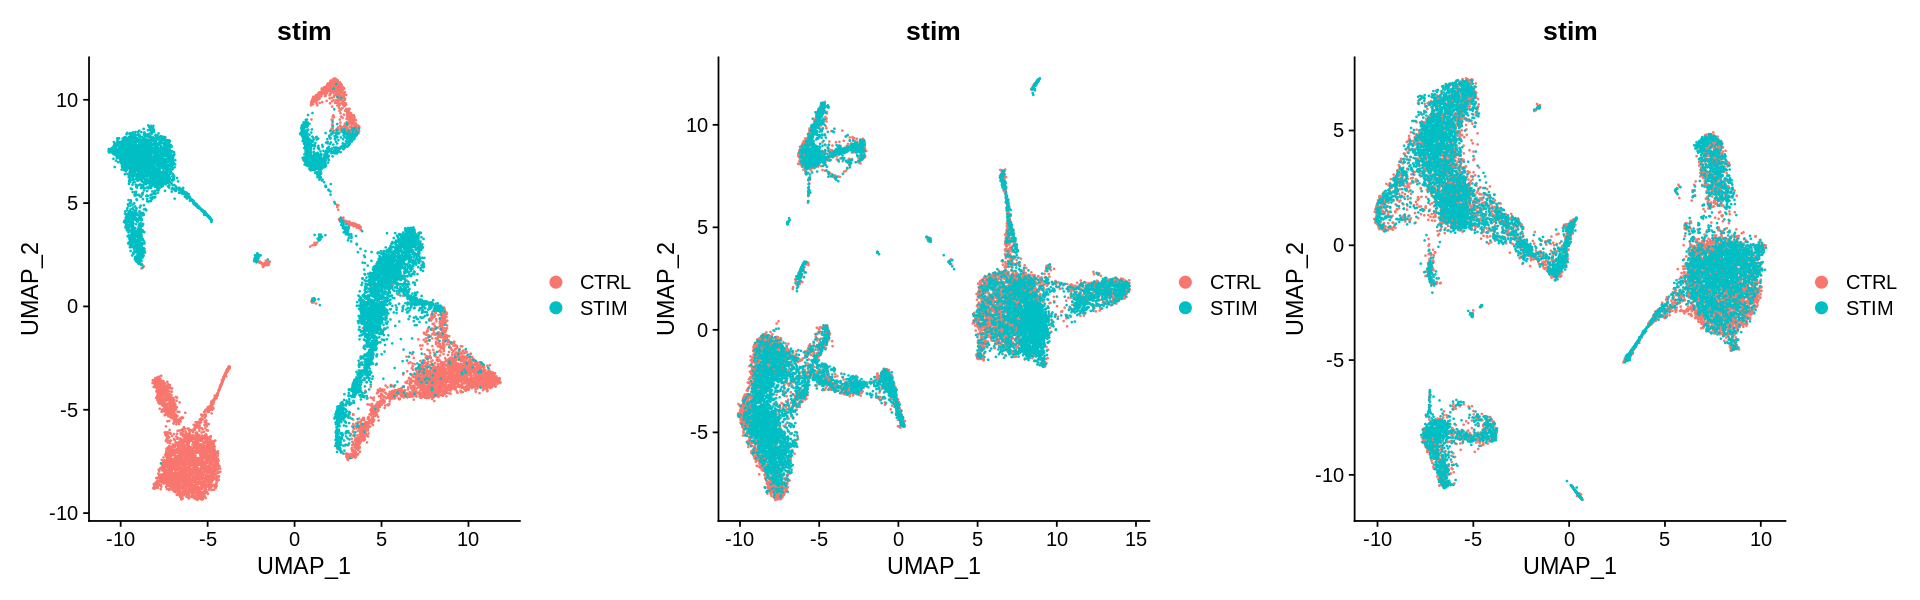

In [ ]:
options(repr.plot.height = 5, repr.plot.width = 16)
# Visualization
p1 <- DimPlot(sc_datasets, reduction = "umap", group.by = "stim")
p2 <- DimPlot(sc_datasets.combined, reduction = "umap", group.by = "stim")
p3 <- DimPlot(sc_datasets.harmony, reduction = "umap", group.by = "stim")

p1 + p2 + p3

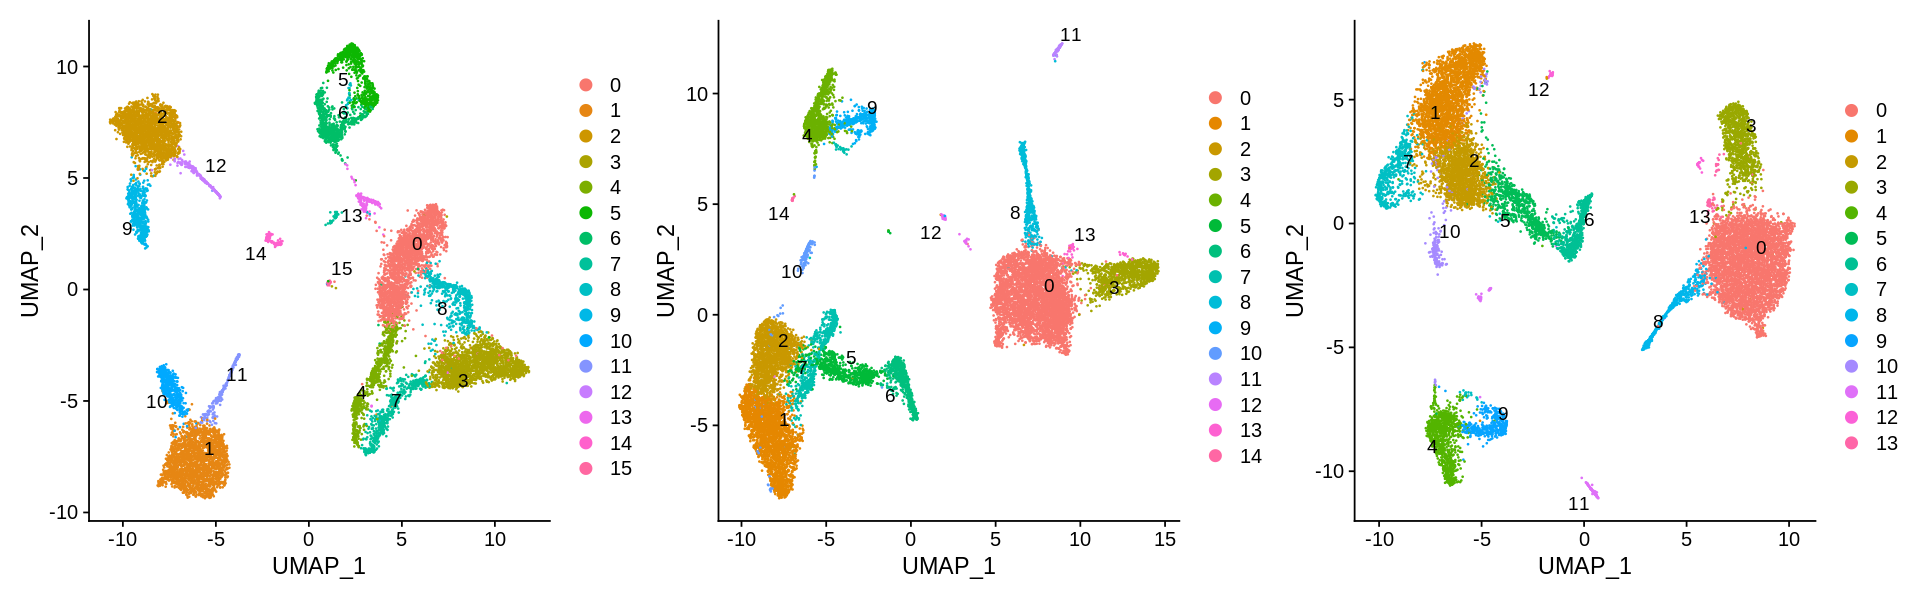

In [ ]:
options(repr.plot.height = 5, repr.plot.width = 16)
# Visualization
p1 <- DimPlot(sc_datasets, reduction = "umap", label = TRUE, repel = TRUE)
p2 <- DimPlot(sc_datasets.combined, reduction = "umap", label = TRUE, repel = TRUE)
p3 <- DimPlot(sc_datasets.harmony, reduction = "umap", label = TRUE, repel = TRUE)

p1 + p2 + p3

## Extra Questions:

- How different are the results between the Seurat and Harmony integration?

- Why can this happen?

- Can you identify which markers changed in the clusters generated in one method vs the other?

In [ ]:
?DimPlot